# MPIA DS Workshop: Introduction to ML

This Notebook is part of the Workshop we gave at MPIA to introduce machine learning.

**Contributors**: Morgan Fouesneau & Iva Momcheva

Last update June, 20 2022

## Setup environment

In [1]:
%%file requirements.txt
matplotlib
pandas
numpy
scikit-learn
torch
astropy
shap

Overwriting requirements.txt


In [2]:
!python3 -m pip install -q -r requirements.txt

You should consider upgrading via the '/root/venv/bin/python3 -m pip install --upgrade pip' command.


## Notebook setup

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import pylab as plt
# The following is only for the presentation
from IPython.display import Markdown, display
plt.style.use('fivethirtyeight')

## Predicting galaxy redshift via regression on 3D-HST photometry

In this notebook, we will try to map a relation between HST measurements and redshift determination.

### Download data

First, we download the 3D-HST catalog from the MAST archive. [Skelton et. al 2014](https://dx.doi.org/10.1088/0067-0049/214/2/24) describe this dataset in details, especially the data selection.

In [4]:
from astropy.utils.data import download_file
import tarfile

file_url = 'https://archive.stsci.edu/missions/hlsp/3d-hst/RELEASE_V4.0/Photometry/3dhst_master.phot.v4.1.tar'
tarfile.open(download_file(file_url, cache=True), "r:")\
       .extract('3dhst_master.phot.v4.1/3dhst_master.phot.v4.1.cat', '.')

Once we have the data on disk, we need to read the combined photmetric catalog. 
Because the catalog is in ASCII format, we use `astropy` and convert the `Table` into a `pandas.dataframe` object. The latter is more convenient with `sklearn` but cannot directly read the ASCII table (it contains misplaced comments).

In [5]:
from astropy.table import Table

df = Table.read('3dhst_master.phot.v4.1/3dhst_master.phot.v4.1.cat', format='ascii')\
          .to_pandas()
df

,id,field,ra,dec,x,y,z_spec,z_peak,faper_F140W,eaper_F140W,...,flags,f140w_flag,star_flag,use_phot,near_star,nexp_f125w,nexp_f140w,nexp_f160w,lmass,Av
0,1.0,AEGIS,215.222382,53.004185,9590.50,3057.30,-1.0000,0.0100,-82.0410,-82.041000,...,0,0,1,0,0,2,0,3,7.51,1.1
1,2.0,AEGIS,215.096588,52.918053,16473.20,3150.20,-1.0000,0.0100,3.5078,0.074233,...,3,0,0,0,0,4,4,4,5.62,0.1
2,3.0,AEGIS,215.161469,52.959461,13060.10,2982.30,-1.0000,0.2062,-1.9043,-1.904300,...,1,0,0,1,0,2,0,2,9.00,1.1
3,4.0,AEGIS,215.305298,53.052921,5422.80,2692.10,-1.0000,0.0355,-72.3250,-72.325000,...,0,0,0,0,0,1,0,1,4.78,0.4
4,5.0,AEGIS,215.041840,52.871273,19894.60,2834.40,-1.0000,0.3427,1890.5000,0.133300,...,0,1,2,0,1,0,3,0,11.57,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207962,44098.0,UDS,34.363106,-5.122067,14578.84,11076.42,-1.0000,0.1852,188.8200,0.170750,...,0,1,2,0,0,0,3,0,10.21,0.2
207963,44099.0,UDS,34.333569,-5.123219,16343.92,11007.12,-1.0000,0.6716,1.7193,0.129080,...,0,1,2,0,0,0,3,0,8.49,0.7
207964,44100.0,UDS,34.363682,-5.123123,14544.39,11013.01,1.4196,2.7489,1.3829,0.113830,...,0,1,2,0,0,0,4,0,9.08,1.4
207965,44101.0,UDS,34.556389,-5.123040,3028.23,11017.04,-1.0000,1.1716,-99.0000,-99.000000,...,1,0,0,0,0,1,0,2,10.55,1.0


### Exploring the dataset

This section aims to examine the contents of the catalog. 

The dataset contains standard information such as target `id`, `field` name, coordinates (`ra`, `dec`), fluxes, uncertainties, and various photometric flags (see [Skelton et. al 2014](https://dx.doi.org/10.1088/0067-0049/214/2/24), or download the [README](https://archive.stsci.edu/missions/hlsp/3d-hst/RELEASE_V4.0/Photometry/master_readme.v4.1.txt) here). 

In addition, there are some derived properties such as photometric redshift (`z_peak`), spectroscopic redshift (`z_spec`), mass (`lmass`) and dust extinction in the V band (`Av`).

[Kriek et al (2018; FAST)](https://ui.adsabs.harvard.edu/abs/2018ascl.soft03008K/abstract) describe the mass estimates.

**Keep in mind that we are interested in predicting redshift, so our "target" variable will be `z_spec`. The "features" will be all relevant columns.**

In [6]:
# Instructor note: let the team explore for ~5 minutes.

The following lists all the columns of the dataset.

In [7]:
df.columns

Index(['id', 'field', 'ra', 'dec', 'x', 'y', 'z_spec', 'z_peak', 'faper_F140W',
       'eaper_F140W', 'faper_F160W', 'eaper_F160W', 'f_F606W', 'e_F606W',
       'f_F814W', 'e_F814W', 'f_F125W', 'e_F125W', 'f_F140W', 'e_F140W',
       'f_F160W', 'e_F160W', 'tot_cor', 'kron_radius', 'a_image', 'b_image',
       'flux_radius', 'fwhm_image', 'flags', 'f140w_flag', 'star_flag',
       'use_phot', 'near_star', 'nexp_f125w', 'nexp_f140w', 'nexp_f160w',
       'lmass', 'Av'],
      dtype='object')

We can also get some statistical description

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,207967.0,2.117321e+04,1.265041e+04,1.000000,10399.000000,20797.000000,31195.500000,5.050700e+04
ra,207967.0,1.220675e+02,7.383123e+01,34.216633,53.061646,150.091034,189.306900,2.153053e+02
dec,207967.0,1.446509e+01,3.538768e+01,-27.959742,-5.272032,2.274822,52.957975,6.238830e+01
x,207967.0,1.215648e+04,7.233914e+03,7.400000,7316.685000,10578.100000,15137.135000,3.766890e+04
y,207967.0,1.023374e+04,5.733813e+03,1273.020000,6161.300000,8873.450000,13184.660000,3.075330e+04
z_spec,207967.0,-9.536530e-01,4.891243e-01,-99.900000,-1.000000,-1.000000,-1.000000,6.118000e+00
z_peak,207967.0,1.177393e+00,6.727479e+00,-99.000000,0.817400,1.415900,2.128050,5.960900e+00
faper_F140W,207967.0,-1.542424e+01,3.237767e+02,-482.630000,-48.633500,0.178810,0.491190,4.705200e+04
eaper_F140W,207967.0,-2.211378e+01,5.445781e+01,-482.630000,-48.633500,0.069309,0.086337,1.059200e+04
faper_F160W,207967.0,1.339273e+01,5.961002e+02,-99.000000,0.186090,0.355380,0.939190,9.118500e+04


In the following, we plot the distribution of all the columns.

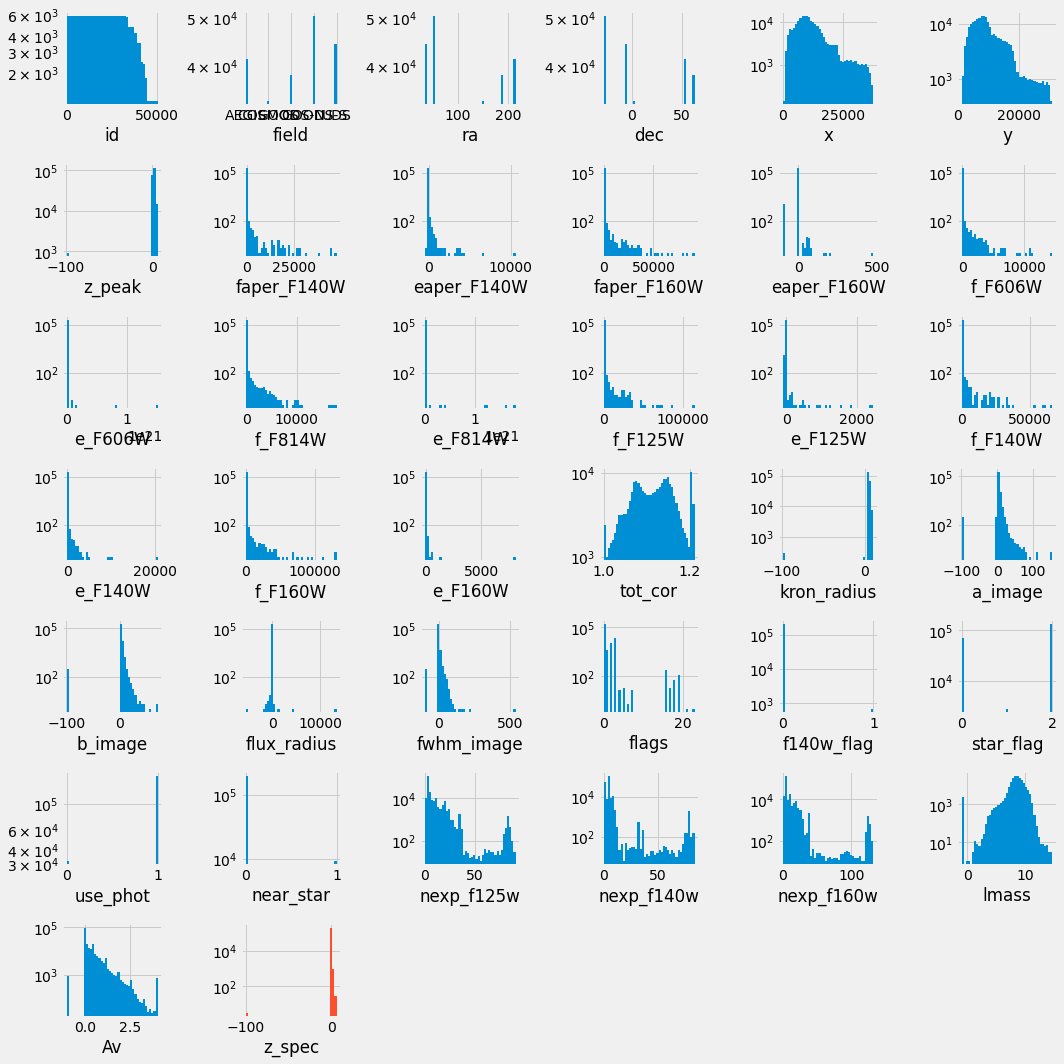

In [9]:
columns = [k for k in df.columns if k != 'z_spec']

wrap = 6

plt.figure(figsize=(15, 15))

nlines = (len(columns) + 1) // wrap +  int((len(columns) + 1) % wrap > 0) 

for e, colname in enumerate(columns, 1):
    plt.subplot(nlines, wrap, e)
    plt.hist(df[colname], bins=43, log=True)
    plt.xlabel(colname)

plt.subplot(nlines, wrap, e + 1)
plt.hist(df['z_spec'], bins=43, log=True, color='C1')
plt.xlabel('z_spec')

plt.tight_layout()

We highlight below the physical relations


> Physical parameters mass vs. redshift. 
We find a pileup of redshit estimates at 0 and even negative estimates. In addition, some
masses are negative. These need to be cleaned for further uses.


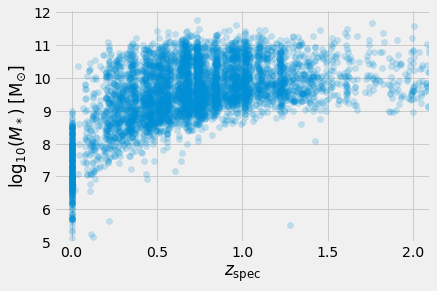

In [10]:
ax = plt.subplot(111)

ax.scatter(df.z_spec, df.lmass, alpha=0.2)
ax.set_xlabel(r'$z_{\rm spec}$')
ax.set_ylabel(r'$\log_{10}{(M_*)}$ [M$_{\odot}$]')
ax.set_xlim(-0.1, 2.1)
ax.set_ylim(5., 12.1);
display(Markdown("""
> Physical parameters mass vs. redshift. 
We find a pileup of redshit estimates at 0 and even negative estimates. In addition, some
masses are negative. These need to be cleaned for further uses.
"""))

**What do we conclude from this exploration?**

Before building and applying a regression model, we have to deal with 
* negative `z_spec` values
* bad values (-99.0) in flux measurements

### Perform data cleaning & select features

**data leakage**:
Data leakage is when information about the label takes part into the training dataset to create the model. This additional information can allow the model to learn or know something that it otherwise would not know and in turn invalidate the estimated performance of the mode being constructed.

For example, if `z_peak`, `lmass` or `z_spec` remain in the training features. Sometimes it could be suddle: for instance including a `MonthlySalary` column when predicting `YearlySalary`; or `MinutesLate` when predicting if a train will be late. 

Data leakage can cause you to create overly optimistic if not completely invalid predictive models.


**Cleaning**:
* only keep sources with $log(M)>9$ to remove sources which do not have complete coverage across redshift.
* remove redshift <= 0. Negative values are bad estimates, and null redshift corresponds to a star. 
* We do not keep `z_phot`, `z_peak`, and `lmass` to avoid leakage.
* The `Av`, `lmass` and `z_peak` values come from the FAST photometric fit, and so we will exclude them as well. 
* We will exclude the categorical flag variables (`flags`, `f140w_flag`, `star_flag`, `use_phot`, `near_star`). To first order redshift estimates should be driven by the flux values. We remove the flags to reduce the feature space. We can check if they help later on.

In [11]:
# Instructor note: Let the team 5 minutes to discuss which features to remove or keep 

In [12]:
remove = ('Av', 'lmass', 'z_peak', 'flags', 'f140w_flag', 'star_flag',
          'use_phot', 'near_star', 'z_spec', 'id', 'field', 
          'ra', 'dec', 'x', 'y')
features = [col for col in df.columns if col not in remove]

target = 'z_spec'

Markdown(f"""
**features** {features}

**target**: {target} """)


**features** ['faper_F140W', 'eaper_F140W', 'faper_F160W', 'eaper_F160W', 'f_F606W', 'e_F606W', 'f_F814W', 'e_F814W', 'f_F125W', 'e_F125W', 'f_F140W', 'e_F140W', 'f_F160W', 'e_F160W', 'tot_cor', 'kron_radius', 'a_image', 'b_image', 'flux_radius', 'fwhm_image', 'nexp_f125w', 'nexp_f140w', 'nexp_f160w']

**target**: z_spec 

### Filter data and impute missing values

Depending on the features we select, we may need to transform text fields into values/categories. The example below shows how to proceed. (Note that we did not decide to keep flags in this notebook)

In [13]:
from sklearn.preprocessing import LabelEncoder
df['field_lbl'] = LabelEncoder().fit_transform(df['field'])

One could also use the `Categorical` conversion from `pandas` here.

By inspection of mass vs redshift, we will only keep sources with $log(M)>9$ to remove sources that do not have complete coverage across redshift.

In [14]:
# Filter the data
df = df[(df['lmass'] > 9) & (df[target] > 0)]

We need to take care of the missing or bad values.

In linear regression problems, the least informative alteration is to use the median or mean of the distribution. In presence of outliers, median would be more robust.

In the following, we use the median of the distributions to replace bad / missing values

In [15]:
# inpute missing data
ecols = [col for col in features if (col[-1] == 'W')]

for col in ecols:
    missing_value = np.nanmedian(df[col])
    df.loc[df[col] < -90, col] = missing_value

/shared-libs/python3.10/py/lib/python3.10/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/shared-libs/python3.10/py/lib/python3.10/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/shared-libs/python3.10/py/lib/python3.10/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [16]:
df_x = df[features]
df_y = df[target]

print("The final training set contains {0:,d} samples and {1:,d} features".format(len(df_x), len(df_x.columns)))

The final training set contains 4,173 samples and 23 features


We plot the 1D distributions again.

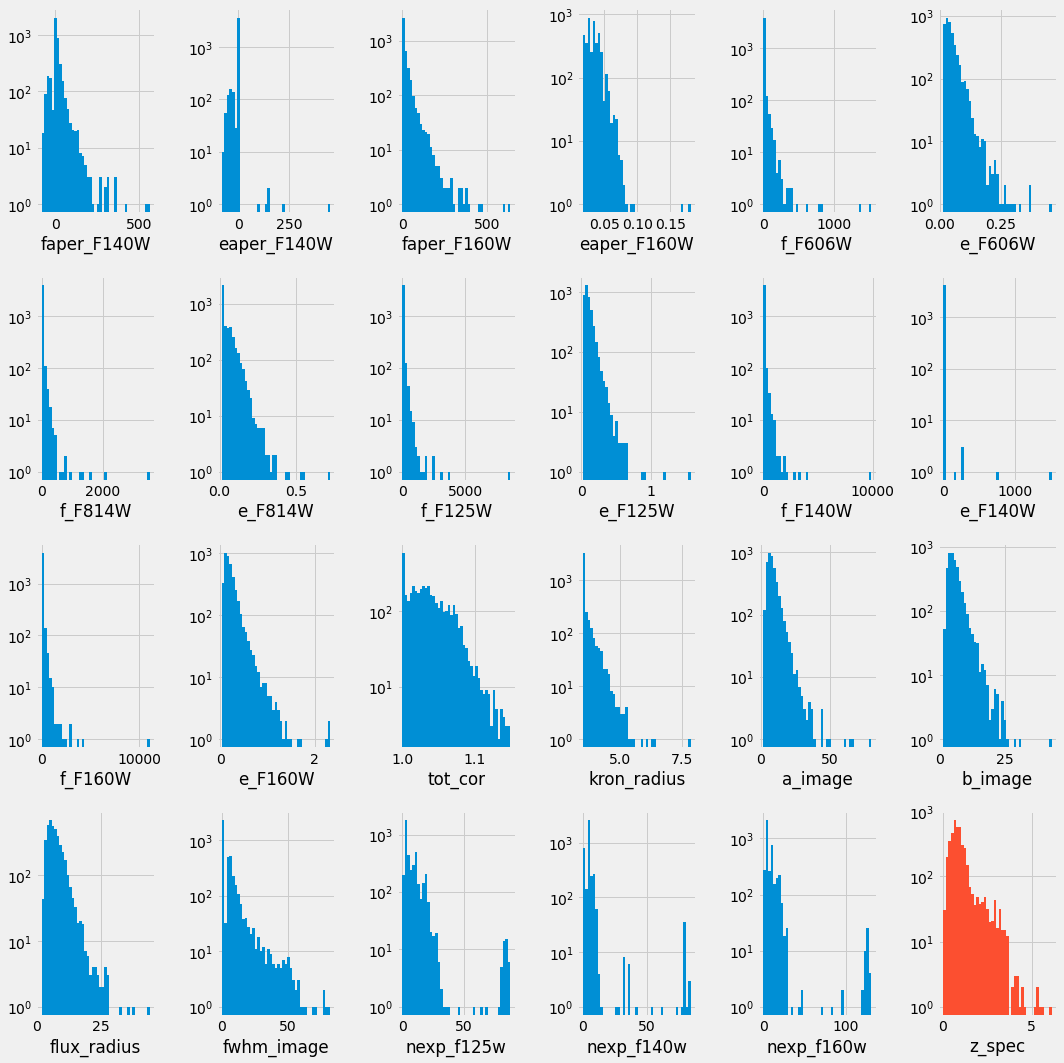

In [17]:
columns = [k for k in df_x.columns]

wrap = 6

plt.figure(figsize=(15, 15))

nlines = (len(columns) + 1) // wrap +  int((len(columns) + 1) % wrap > 0) 

for e, colname in enumerate(columns, 1):
    plt.subplot(nlines, wrap, e)
    plt.hist(df_x[colname], bins=43, log=True)
    plt.xlabel(colname)

plt.subplot(nlines, wrap, e + 1)
plt.hist(df_y, bins=43, log=True, color='C1')
plt.xlabel(target)

plt.tight_layout()

As we are about to make a linear regression model, we can look into the correlations between all the features and `z_spec` as below.

<BarContainer object of 23 artists>

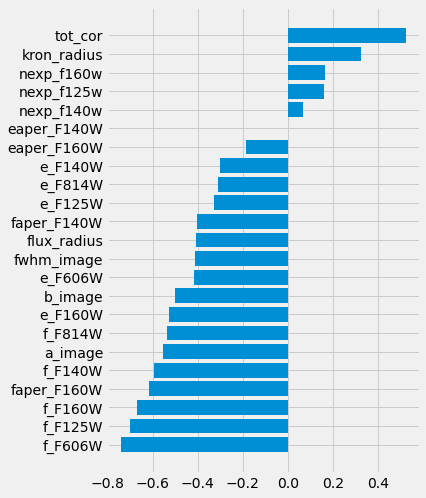

In [18]:
plt.figure(figsize=(5, 8))
corr = df_x.corrwith(df_y, method='spearman')
corr = corr.sort_values()
plt.barh(np.arange(len(corr)), corr, 
         tick_label=corr.index)

These correlations make sense:
* the width of a source indicates that we see the host galaxy, hence a low-redshift source.
* the fluxes link to the photometric redshift, which is when the various lines move from the blue bands to the redder ones.
...

### Divide the data into train, test and validation sets

Note that typically one needs to pass arrays to the common libraries. 

```python
X = df[features].values
y = df[target].values
```

However, `Scikit-learn` has implemented pandas interfaces, so we do not need to do so in this particular exercise.
(Careful with the version of `sklearn` you use to benefit from this interface)



In [19]:
import sklearn
print("sklearn version: ", sklearn.__version__)

sklearn version:  1.1.1


Divide the data into train, validation and test sets. We will use the following definitions:

* **Training**: The data used to update model parameters (e.g., coefficients or matrix element values).

* **Validation**: The data used to update model selection (for instance, we might change hyperparameters of a model based on the validation metrics).

* **Testing**: The data used to make final predictions, and possibly evaluate the final model score.

In [20]:
from sklearn.model_selection import train_test_split

# first reserve 70% of the data for training, 30% for validation
X_train, X_validate, y_train, y_validate = train_test_split(df_x, df_y, test_size=0.3, random_state=42)

# second, split the validation set in half to obtain validation and test sets. 
X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, test_size=0.5, random_state=42)

### Explore regression models

Here we explore a few options for regressor models.
You can find all available models on the [sklearn documentation](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning).

One particular convenience of `sklearn` is its standard API for any model. You can test almost anything with four steps:
* `from sklearn.<path> import Model`
* `model = Model(**parameters)`, where `parameters` will vary from model type to model type.
* `model.fit(X_train, y_train)`
* `ypred = model.predict(X_test)`

#### Linear Regression 

Let's do a simple one first

In [21]:
# Instructor note: this example is guided

In [22]:
from sklearn.linear_model import LinearRegression

In [23]:
lin = LinearRegression()
lin.fit(X_train, y_train)

LinearRegression()

To quantify the performance of the model, we will apply it to the validation set and compare the predicted values with the true values by computing the mean squared error:

MSE = 0.2745


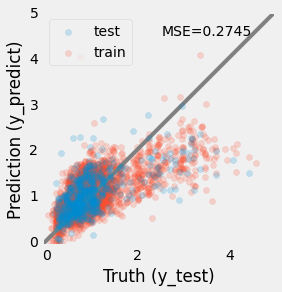

In [24]:
from sklearn.metrics import mean_squared_error

y_predict = lin.predict(X_test)
y_predict0 = lin.predict(X_train)
mse = mean_squared_error(y_test, y_predict)
print(f'MSE = {mse:.4f}')

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(y_test, y_predict, alpha=0.2, label='test')
ax.scatter(y_train, y_predict0, alpha=0.2, label='train', zorder=-1)
ax.plot(ax.get_xlim(), ax.get_xlim(), zorder=-1, color='0.5')
ax.set_aspect('equal')
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.grid()
ax.set_xlabel('Truth (y_test)')
ax.set_ylabel('Prediction (y_predict)')
plt.legend(loc='upper left')
ax.text(0.9, 0.9, f"MSE={mse:0.4f}", transform=ax.transAxes, ha='right');

This plot shows that the linear regression model is getting the bulk of the data but performs poorly when the data becomes sparse, i.e. $z > 1.5$.

Overall the MSE is not great. Not surprising given the simplicity of our model. Maybe we can do better changing it?



We could also examine the coefficients of each feature from the model using the 
`LinearRegression.coef_` attribute.

Text(0.5, 0, 'Lin. Coeffs')

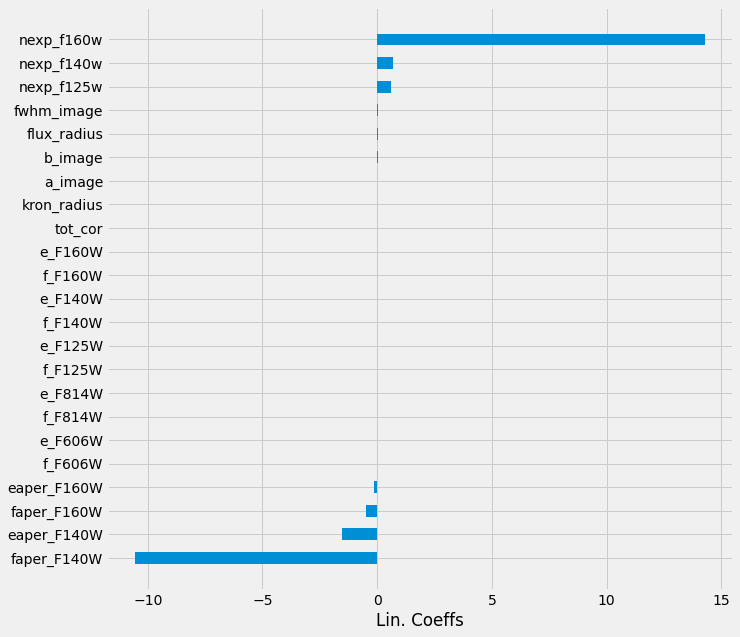

In [26]:
importances = lin.coef_
labels = lin.feature_names_in_
# older version: labels = df_x.columns
argsort = np.argsort(importances)
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)
ax.barh(np.arange(len(df_x.columns)), importances[argsort], 
        align='center', 
        height=0.5, 
        tick_label=labels)
ax.set_xlabel("Lin. Coeffs")

However, note here that we have features with very different dynamical ranges. Hence comparing feature amplitudes does not reflect how important these are for the model. One would need to normalize the dimensions first. (We do so in the next model.)

#### Polynomial regression model

In this section, we explore a polynomial model. Such a model takes an input feature vector $X=(a, b)$ and turns it into $X^\prime=(1, a, b, a^2, b^2, a\cdot b)$ for a degree=2 polynomial.

see `sklearn.preprocessing.PolynomialFeatures`

To make this modeling more robust, we will also normalize the data. We will use 

see `sklearn.preprocessing.StandardScaler`

We will also switch from a traditional linear regression to a **regularized** regression. This regularization is one or multiple additional terms in the loss function that penalizes the number of non-null coefficients. 

see for example: `sklearn.linear_model.LassoLars`, `sklearn.linear_model.ElasticNet`

In the following we use `sklearn.linear_model.LassoLarsIC`, a lasso model fit with Lars using BIC or AIC for model selection (setting how strong the penalization should be).

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LassoLarsIC

pipe = Pipeline([
    ('polynomial', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler()),
    ('classifier', LassoLarsIC(normalize=False))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('polynomial', PolynomialFeatures()),
                ('scaler', StandardScaler()),
                ('classifier', LassoLarsIC(normalize=False))])

In the above, we also use `Pipeline`, which is a convenient wrapper around sequential steps:
here, we expand `X_train` to a polynomial of degree=2, then standardize the data before applying the regressor. `Pipeline` is an object that understands the API and knows which functions to call for each step.

Manually, the `pipe.fit` would be something like
```
Xprime = polynomial.fit_transform(X_train)
Xscaled = scaler.fit_transform(Xprime)
classifier.fit(X_train, y_train)
```

Then to predict values, similar steps would be necessary
```
Xprime = polynomial.transform(X_test)
Xscaled = scaler.fit_transform(Xprime)
ypred = classifier.fit(X_test, y_test)
```
but `pipe.predict` is more convenient.


MSE = 0.2163


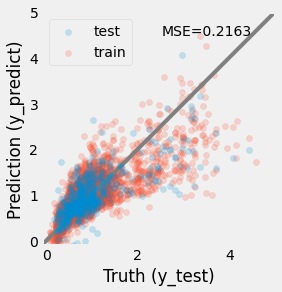

In [37]:
y_predict = pipe.predict(X_test)
y_predict0 = pipe.predict(X_train)
mse = mean_squared_error(y_test, y_predict)
print(f'MSE = {mse:.4f}')

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(y_test, y_predict, alpha=0.2, label='test')
ax.scatter(y_train, y_predict0, alpha=0.2, label='train', zorder=-1)
ax.plot(ax.get_xlim(), ax.get_xlim(), zorder=-1, color='0.5')
ax.set_aspect('equal')
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.grid()
ax.set_xlabel('Truth (y_test)')
ax.set_ylabel('Prediction (y_predict)')
plt.legend(loc='best')
ax.text(0.9, 0.9, f"MSE={mse:0.4f}", transform=ax.transAxes, ha='right');

The results look better. The $z > 1.5$ looks closer to the identity line, but still not perfect.

Text(0.5, 0, 'Normalized Coeffs')

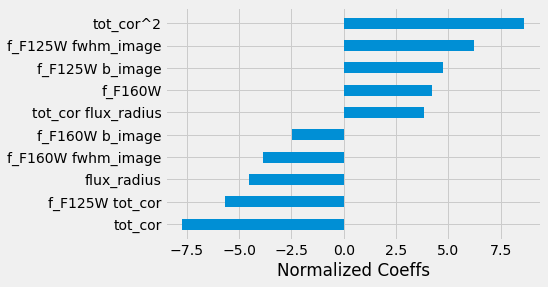

In [46]:
importances = pipe['classifier'].coef_
labels = pipe['polynomial'].get_feature_names_out()
# older version: labels = df_x.columns
argsort = np.argsort(np.abs(importances))   # absolute importance

show_n = 10
argsort = argsort[-show_n:]
importances = importances[argsort]
labels = labels[argsort]
argsort = np.argsort(importances)   # for aesthetic

# fig = plt.figure(figsize=[10, 30])
plt.figure()
ax = plt.subplot(111)
ax.barh(np.arange(len(labels)), importances[argsort], 
        align='center', 
        height=0.5, 
        tick_label=labels[argsort])
ax.set_xlabel("Normalized Coeffs")

In [ ]:
# instructor note: let the team explore 
#    * other regression models, 
#    * play with the polynomial degree

The residuals of our linear regression models are not great. We can explore other kinds of models.

Using sklearn, it is very easy to change a model for something different.

#### Random Forest

Using sklearn, we can very easily construct a decision tree model for regressing redshift from the photometric catalog features. A decision tree is composed of a series of if-else decision steps. The number of steps and the types of decision at each step is determined by training the algorithm with supervision. In this first example, we will use the DecisionTreeRegressor from sklearn.

In [30]:
from sklearn.ensemble import RandomForestRegressor

# use the same parameters as the Decision Tree

# Initialize the model
rf = RandomForestRegressor()

rf.fit(X_train, y_train)

RandomForestRegressor()

MSE = 0.1197


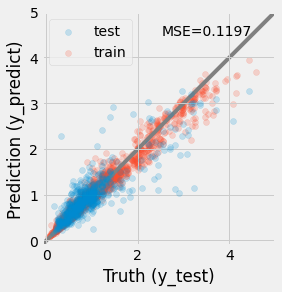

In [31]:
y_predict = rf.predict(X_test)
y_predict0 = rf.predict(X_train)
mse = mean_squared_error(y_test, y_predict)
print(f'MSE = {mse:.4f}')

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(y_test, y_predict, alpha=0.2, label='test')
ax.scatter(y_train, y_predict0, alpha=0.2, label='train', zorder=-1)
ax.plot(ax.get_xlim(), ax.get_xlim(), zorder=-1, color='0.5')
ax.set_aspect('equal')
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.set_xlabel('Truth (y_test)')
ax.set_ylabel('Prediction (y_predict)')
plt.legend(loc='best')
ax.text(0.9, 0.9, f"MSE={mse:0.4f}", transform=ax.transAxes, ha='right');

The results are much improved by the random forest! 

However, we must be cautious. It is possible that this model suffers from **over-fitting**. To visualize overfitting, we can compare the mean squared error (MSE) for models of increasing max_depth on the training and testing sets:

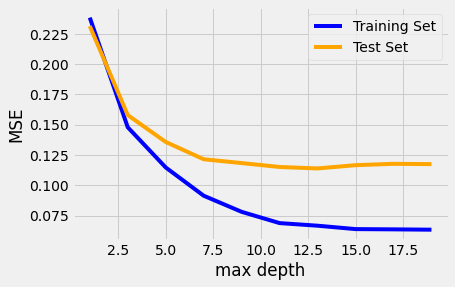

In [32]:
max_depths = np.arange(1, 20, 2).astype(int)

train_mse = []
test_mse = []

params = {
    "min_samples_split": 15,
    "min_samples_leaf": 5,
}

for depth in max_depths:

    rff_ = RandomForestRegressor(max_depth=depth, **params)
    rff_.fit(X_train, y_train)
    
    y_predict_train = rff_.predict(X_train)
    y_predict_test = rff_.predict(X_test)
    
    train_mse.append(mean_squared_error(y_train, y_predict_train))
    test_mse.append(mean_squared_error(y_test, y_predict_test))

    
fig, ax = plt.subplots(1, 1)

ax.plot(max_depths, train_mse, color='blue', label='Training Set')
ax.plot(max_depths, test_mse, color='orange', label='Test Set')
ax.set_xlabel('max depth')
ax.set_ylabel('MSE')
ax.legend()

Beyond a max_depth of ~10, the MSE on the training set declines while the MSE on the test set flattens out, suggesting some amount of over-fitting: the flattening indicates that the model does not learn anything more, so we can stop the complexity early.

Note that sometimes, the residuals could increase again on the test set.

To explore further, we will explore how general our model performance (here quantifed with MSE) is using k-fold cross-validation via sklearn. In practice, the X and y datasets are split into k “folds”, and over k iterations, the model is trained using k-1 folds as training data and the remaining fold as a test set to compute performace (i.e., MSE).

In [47]:
from sklearn.model_selection import cross_validate

cv = cross_validate(
    estimator=rf, 
    X=df_x, 
    y=df_y, 
    cv=5, # number of folds
    scoring='neg_mean_squared_error'
)

print(f'Cross-validated score: {cv["test_score"].mean():.3f} +/- {cv["test_score"].std():.3f}')

Cross-validated score: -0.140 +/- 0.051


The previous MSE is consistent with the cross-validated MSE, suggesting that the model is not significantly over-fitting.

Next, we’ll observe which features are most important to the model predictions. Note that as trees implements selections per dimensions, a normalization of the data is not necessary.

Text(0.5, 0, 'Feature importance')

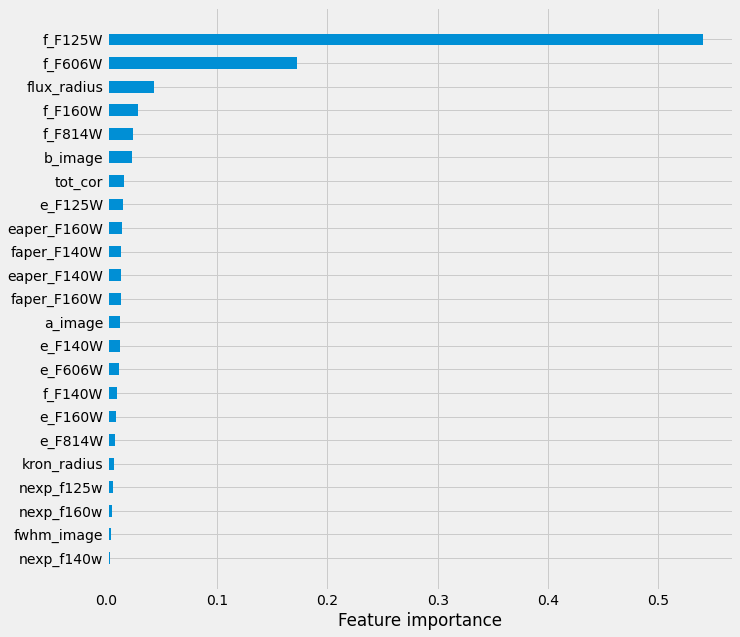

In [34]:
importances = rf.feature_importances_
argsort = np.argsort(importances)
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)
ax.barh(np.arange(len(df_x.columns)), importances[argsort], 
        align='center', 
        height=0.5, 
        tick_label=np.array(features)[argsort])
ax.set_xlabel("Feature importance")

Warning: the feature importance in trees is not robust due to the manner they are build (see also sklearn documentation). In practice, these are indicative, but if you need a proper characterization, you will need something like the SHAP values (SHapley Additive exPlanations), e.g. [SHAP package](https://shap.readthedocs.io/en/latest/index.html).

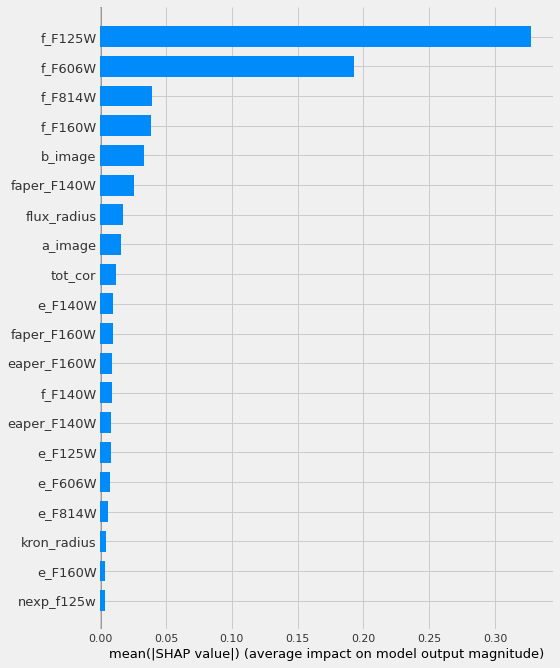

In [50]:
import shap
shap_values = shap.TreeExplainer(rf).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

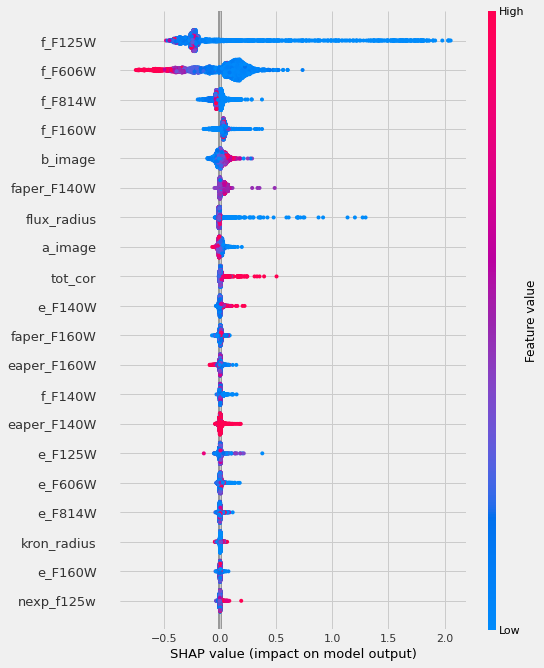

In [53]:
import matplotlib.pyplot as plt
f = plt.figure()
shap.summary_plot(shap_values, X_train)

SHAP values are expensive to compute, these are equivalent to a leave-one-out procedure on each feature.
However, they also provide more insight into what information pieces are relevant to the model.

#### Other tree-based model

Here we use an Histogram-based Gradient Boosting Regression Tree: `sklearn.ensemble.HistGradientBoostingRegressor`. This particular model is fast to train and represents an approximation to `lightGBM` models. 

In [54]:
from sklearn.ensemble import HistGradientBoostingRegressor

# Initialize the model
et = HistGradientBoostingRegressor()

et.fit(X_train, y_train)

HistGradientBoostingRegressor()

MSE = 0.1291


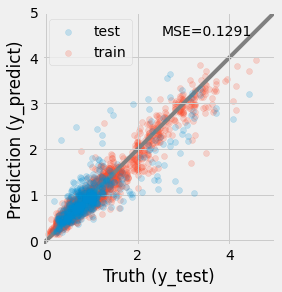

In [55]:
y_predict = et.predict(X_test)
y_predict0 = et.predict(X_train)
mse = mean_squared_error(y_test, y_predict)
print(f'MSE = {mse:.4f}')

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(y_test, y_predict, alpha=0.2, label='test')
ax.scatter(y_train, y_predict0, alpha=0.2, label='train', zorder=-1)
ax.plot(ax.get_xlim(), ax.get_xlim(), zorder=-1, color='0.5')
ax.set_aspect('equal')
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.set_xlabel('Truth (y_test)')
ax.set_ylabel('Prediction (y_predict)')
plt.legend(loc='best')
ax.text(0.9, 0.9, f"MSE={mse:0.4f}", transform=ax.transAxes, ha='right');

In [56]:
cv = cross_validate(
    estimator=et, 
    X=df_x, 
    y=df_y, 
    cv=5, # number of folds
    scoring='neg_mean_squared_error'
)

print(f'Cross-validated score: {cv["test_score"].mean():.3f} +/- {cv["test_score"].std():.3f}')

Cross-validated score: -0.143 +/- 0.055


#### Combining feature expansion and tree models

Here we combine approaches from above.

In [57]:
pipe2 = Pipeline([
    ('polynomial', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler()),
    ('classifier', HistGradientBoostingRegressor())
])

pipe2.fit(X_train, y_train)

Pipeline(steps=[('polynomial', PolynomialFeatures()),
                ('scaler', StandardScaler()),
                ('classifier', HistGradientBoostingRegressor())])

MSE = 0.1312


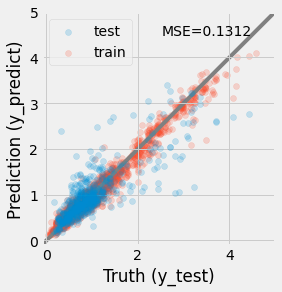

In [58]:
y_predict = pipe2.predict(X_test)
y_predict0 = pipe2.predict(X_train)
mse = mean_squared_error(y_test, y_predict)
print(f'MSE = {mse:.4f}')

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(y_test, y_predict, alpha=0.2, label='test')
ax.scatter(y_train, y_predict0, alpha=0.2, label='train', zorder=-1)
ax.plot(ax.get_xlim(), ax.get_xlim(), zorder=-1, color='0.5')
ax.set_aspect('equal')
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.set_xlabel('Truth (y_test)')
ax.set_ylabel('Prediction (y_predict)')
plt.legend(loc='best')
ax.text(0.9, 0.9, f"MSE={mse:0.4f}", transform=ax.transAxes, ha='right');

#### Check against each other and reference

We need to see if we perform decently against the FAST work.

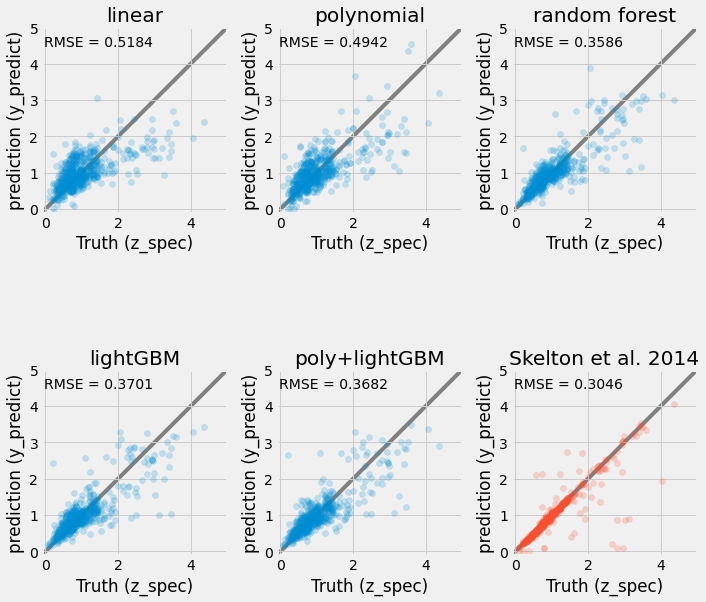

In [59]:
y_values = [lin.predict(X_validate),
            pipe.predict(X_validate),
            rf.predict(X_validate),
            et.predict(X_validate),
            pipe2.predict(X_validate),
            df['z_peak'].loc[X_validate.index]
]

names = ['linear', 'polynomial', 'random forest', 'lightGBM', 'poly+lightGBM', 'Skelton et al. 2014']


fig, ax = plt.subplots(2, len(names) // 2 , figsize=(10, 10))

for k, (ax, yval) in enumerate(zip(np.ravel(ax), y_values)):
    color = 'C0'
    if k == len(names) - 1:
        color = 'C1'
    ax.scatter(y_validate, yval, alpha=0.2, color=color)
    ax.set_aspect('equal')
    ax.set_xlim(-0.1, 5)
    ax.set_ylim(-0.1, 5)
    ax.plot(ax.get_xlim(), ax.get_xlim(), zorder=-1, color='0.5')
    ax.set_xlabel('Truth (z_spec)')
    ax.set_ylabel('prediction (y_predict)')
    ax.set_title(names[k])
    mse = mean_squared_error(y_validate, yval, squared=False)
    ax.text(0.01, 0.9, f'RMSE = {mse:.4f}', transform=ax.transAxes)

plt.tight_layout()

### Going further

* What if you include galaxy colors (e.g., F125W-F140W, F140W-F160W, F606W-F125W)? do the model results improve? Can you think of other features to include?

* Can you tune the model parameters with a grid search? 

* What if you try other models from sklearn?

### Neural Networks

In the following, we explore mapping models of `z_spec` with neural networks.

We use `torch`, one of the most popular libraries.

#### Linear regression

A linear regression with a neural network corresponds to a single linear layer, i.e. a weighted sum.

The following gives how the code would look with `torch`. For explanation, we will refer to the documentation of torch.

In [106]:
import torch

class LinearNNRegressor(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super().__init__()
        self.sequence = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        return self.sequence(x)

In [110]:
model = LinearNNRegressor(len(features), 1)
model

LinearNNRegressor(
  (sequence): Linear(in_features=23, out_features=1, bias=True)
)

We then need to optimize all the network's parameters (here 24) w.r.t. a loss function.

The optimization is an iterative process, each iteration traditionally called `epoch`

In [107]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.2)
criterion = torch.nn.MSELoss()
epochs = 500

# always be careful to normalize your data.
x_scaler = StandardScaler()
X_scaled = np.squeeze(x_scaler.fit_transform(X_train))

# convert the data to torch memory space
inputs = torch.from_numpy(X_scaled.astype('float32'))
labels = torch.from_numpy(y_train.to_numpy().astype('float32').reshape(-1, 1))

The following runs the optimization and keep logs of the loss values for diagnostic plots.

In [109]:
# monitoring
history = []

for epoch in range(epochs):
    # Clear gradient buffers because we don't want any gradient 
    # from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    if epoch % 100 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.item()))
    history += [[epoch, float(loss)]]    
    #scheduler.step()

print(f"Epoch= {epoch},\t loss = {loss:2.4g}")
print('done.')

epoch 0, loss 1.780137062072754
epoch 100, loss 0.25033095479011536
epoch 200, loss 0.2495516687631607
epoch 300, loss 0.2492332011461258
epoch 400, loss 0.24909107387065887
Epoch= 499,	 loss = 0.249
done.


We can then plot the loss evolution

Text(0, 0.5, 'loss MSE')

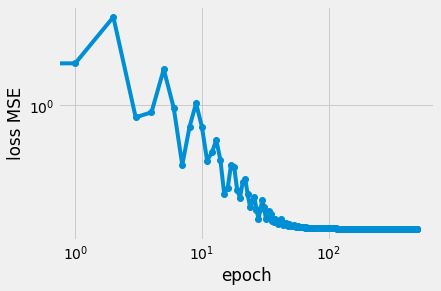

In [101]:
plt.loglog([e for (e, l) in history], 
           [float(l) for (e, l) in history], 'o-')
plt.xlabel('epoch')
plt.ylabel('loss MSE')

The loss values seem to converge to a given value.

Let's plot the predictions

In [102]:
y_predict = model(
    torch.from_numpy(x_scaler.transform(X_test).astype('float32'))
    ).cpu().detach().numpy()  
y_predict0 = model(
    torch.from_numpy(x_scaler.transform(X_train).astype('float32'))
    ).cpu().detach().numpy()  

MSE = 0.2742


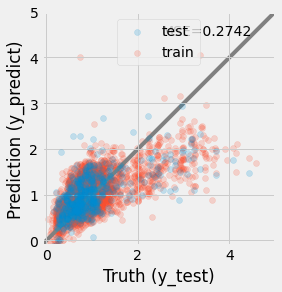

In [103]:
mse = mean_squared_error(y_test, y_predict)
print(f'MSE = {mse:.4f}')

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(y_test, y_predict, alpha=0.2, label='test')
ax.scatter(y_train, y_predict0, alpha=0.2, label='train', zorder=-1)
ax.plot(ax.get_xlim(), ax.get_xlim(), zorder=-1, color='0.5')
ax.set_aspect('equal')
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.set_xlabel('Truth (y_test)')
ax.set_ylabel('Prediction (y_predict)')
plt.legend(loc='best')
ax.text(0.9, 0.9, f"MSE={mse:0.4f}", transform=ax.transAxes, ha='right');

As expected, we recover the performance of our previous linear regression model, with all the issues we identified before.

#### Deep network regression

This section explores more complex network, with hidden layers.

This such network is traditionally called `deep` network: the network contains hidden layers and activation functions.

In [60]:
## Define a moduel deform
from typing import Sequence
import torch

class DNNRegressor(torch.nn.Module):
    def __init__(self, n_input: int, 
                 n_hidden: Sequence[int], 
                 n_output: int):
        super().__init__()
    
        self.sequence = torch.nn.Sequential()
        # add input layer
        self.sequence.add_module("input", 
                                 torch.nn.Linear(n_input, n_hidden[0]))
        # set hidden layers
        for e, (n1, n2) in enumerate(zip(n_hidden[:-1], n_hidden[1:])):
            self.sequence.add_module(f"hidden_{e:d}", 
                                     torch.nn.Linear(n1, n2))
            #self.sequence.add_module(f"dropout_{e:d}", 
            #                         torch.nn.Dropout(p=0.1))
            self.sequence.add_module(f"activation_{e:d}", 
                                     torch.nn.SELU())
        # set output layer    
        self.sequence.add_module("output",  
                                 torch.nn.Linear(n_hidden[-1], n_output))

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        return self.sequence(x)

criterion = torch.nn.MSELoss()

In [77]:
model = DNNRegressor(len(features), [32, 32], 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
criterion = torch.nn.MSELoss()
epochs = 2_000

# always be careful to normalize your data.
x_scaler = StandardScaler()
X_scaled = np.squeeze(x_scaler.fit_transform(X_train))
inputs = torch.from_numpy(X_scaled.astype('float32'))
labels = torch.from_numpy(y_train.to_numpy().astype('float32').reshape(-1, 1))

# monitoring
history = [] 

for epoch in range(epochs):
    # Clear gradient buffers because we don't want any gradient 
    # from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    if epoch % 100 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.item()))
    history += [[epoch, float(loss)]]    
    #scheduler.step()

print(f"Epoch= {epoch},\t loss = {loss:2.4g}")
print('done.')

epoch 0, loss 0.9641375541687012
epoch 100, loss 0.4040732681751251
epoch 200, loss 0.28275415301322937
epoch 300, loss 0.2564278244972229
epoch 400, loss 0.24285411834716797
epoch 500, loss 0.23361913859844208
epoch 600, loss 0.22604605555534363
epoch 700, loss 0.22027161717414856
epoch 800, loss 0.2156827747821808
epoch 900, loss 0.2118762582540512
epoch 1000, loss 0.2082682102918625
epoch 1100, loss 0.20499546825885773
epoch 1200, loss 0.20215877890586853
epoch 1300, loss 0.19946059584617615
epoch 1400, loss 0.1969391405582428
epoch 1500, loss 0.19462497532367706
epoch 1600, loss 0.19193904101848602
epoch 1700, loss 0.1887429803609848
epoch 1800, loss 0.1851634681224823
epoch 1900, loss 0.18236300349235535
Epoch= 1999,	 loss = 0.18
done.


Text(0, 0.5, 'loss MSE')

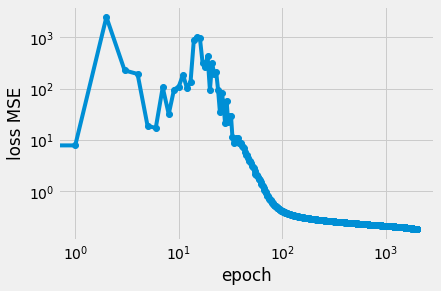

In [78]:
plt.loglog([e for (e, l) in history], 
           [float(l) for (e, l) in history], 'o-')
plt.xlabel('epoch')
plt.ylabel('loss MSE')

In [79]:
y_predict = model(
    torch.from_numpy(x_scaler.transform(X_test).astype('float32'))
    ).cpu().detach().numpy()  
y_predict0 = model(
    torch.from_numpy(x_scaler.transform(X_train).astype('float32'))
    ).cpu().detach().numpy()  

MSE = 0.1873


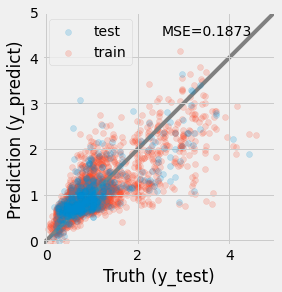

In [80]:
mse = mean_squared_error(y_test, y_predict)
print(f'MSE = {mse:.4f}')

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(y_test, y_predict, alpha=0.2, label='test')
ax.scatter(y_train, y_predict0, alpha=0.2, label='train', zorder=-1)
ax.plot(ax.get_xlim(), ax.get_xlim(), zorder=-1, color='0.5')
ax.set_aspect('equal')
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.set_xlabel('Truth (y_test)')
ax.set_ylabel('Prediction (y_predict)')
plt.legend(loc='best')
ax.text(0.9, 0.9, f"MSE={mse:0.4f}", transform=ax.transAxes, ha='right');

#### Going further

* What architecture would lead to better results?
* Would other layers help?
* What is the impact of the optimizer?


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4407348b-08d6-4b91-87db-377c8afa151e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>